## Transfer Learning

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
''' 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기 (Train set, Test set 분리하기) '''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 해당 이미지를 224 사이즈로 변경하되, 변경되는 이미지 픽셀 값은 랜덤으로 선택 즉, 이미지 내 랜덤으로 선택해 224 사이즈로 변경
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("./data/hymenoptera_data", # 이미지 데이터를 불러오며, 해당 위치에 접근해 train 폴더와 val 폴더에 접근해 데이터를 불러옴
                                         data_transforms[x]) for x in ['train', 'val']} # 기존에 정의한 data_transform의 학습과 검증 데이터셋에 전처리 과정을 적용
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], # 위에서 불러온 이미지를 Mini-Batch 단위로 구분하기 위해 DataLoader 함수 사용, 학습 데이터셋과 검증 데이터셋에 각각 적용하기 위해 딕셔너리 구조 사용
                                            batch_size = BATCH_SIZE, # Mini-Batch를 구성하는 데이터 개수는 기존에 정의한 BATCH_SIZE
                                            num_workers = 0,  # 처리하는 프로세싱에 관련된 내용이며, 멀티 프로세싱으로 진행하지 않기 위해 0을 기본값으로 이용
                                            shuffle = True) for x in ['train', 'val']}  # 학습 데이터셋과 검증 데이터셋을 각각 진행한 결과는 딕셔너리에 저장하며, 데이터 순서를 섞음

In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
# X train: 32개의 이미지 데이터가 1개의 Mini-Batch를 구성하며, 가로 224개, 세로 224개의 픽셀로 구성된 3채널 이미지 데이터
# y train: 32개의 이미지 데이터 각각에 대해 label값이 1개씩 존재하기 때문에 32개의 값을 갖고 있음

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

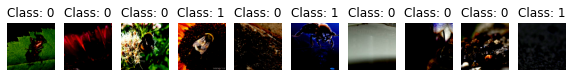

In [7]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [9]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [10]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [11]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
''' 10. 미리 학습되지 않은 ResNet18 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.758054
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.733778
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.902249

[EPOCH: 1], 	Test Loss: 0.7737, 	Test Accuracy: 61.46 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.726344
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.672193
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.603839

[EPOCH: 2], 	Test Loss: 0.9010, 	Test Accuracy: 38.54 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.612869
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.672285
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.669737

[EPOCH: 3], 	Test Loss: 0.6991, 	Test Accuracy: 61.46 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.650631
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.592772
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.661764

[EPOCH: 4], 	Test Loss: 0.7175, 	Test Accuracy: 62.47 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.599974
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.626040
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.692371

In [13]:
''' 11. IMAGENET 데이터로 미리 학습이 된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기 '''
model = models.resnet18(pretrained = True)

# 전체 네트워크를 Fine-tuning 하지않고, 사전학습된 네트워크를 고정된 특징 추출기로 사용하며, 뒤의 FCL만 학습
# for param in model.parameters():
#     param.requires_grad = False
# 학습 속도 측면에선 유리할 수 있으나, 클래스가 많은 상황에서는 성능이 낮게 나올 수 있음

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()



optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\lucky/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.805246
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.765880
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.934992

[EPOCH: 1], 	Test Loss: 0.6316, 	Test Accuracy: 68.51 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.586128
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.441226
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.497139

[EPOCH: 2], 	Test Loss: 0.5719, 	Test Accuracy: 71.28 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.660608
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.366465
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.423696

[EPOCH: 3], 	Test Loss: 0.4789, 	Test Accuracy: 77.83 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.376739
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.463110
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.470423

[EPOCH: 4], 	Test Loss: 0.3729, 	Test Accuracy: 88.41 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.365160
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.385636
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.565247